Spooky Author Identification
=============

Data Exploration
------------

This notebook will be used to import the data files, and explore the style of each spooky author using statistics of different features.

In [1]:
# All the modules that will be used later
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk import FreqDist
import string

Read the train and test set.

In [2]:
train = pd.read_csv('train.csv')
print('Train data size: ', train.shape)

Train data size:  (19579, 3)


In [3]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


Let's check whether the classes are balanced in train dataset - whether the number of train examples of each author is close.

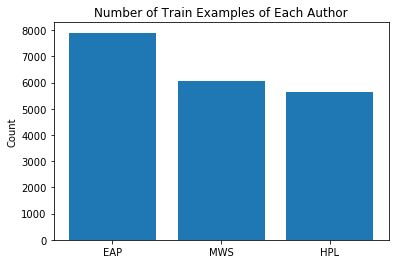

In [4]:
authors = train['author'].value_counts()
x_pos = np.arange(len(authors))
plt.figure()
plt.bar(x_pos, authors.values, align = 'center')
plt.xticks(x_pos, authors.index)
plt.ylabel('Count')
plt.title('Number of Train Examples of Each Author')
plt.show()

The classes look quite balanced in the train dataset.

Then, let's calculate some sentence statistics to explore the writing style of each author. The sentence statistics include:

- Number of words in the sentence
- Proportion of unique words in the sentence
- Proportion of stop words in the sentence
- Proportion of punctuations in the sentence
- Proportion of nouns in the sentence
- Proportion of verbs in the sentence

As the lengths of sentences vary a lot in the train dataset, most of the statistics are normalized by sentence length, otherwise their distribution will be largely impacted by sentence length.

In [5]:
train_feats = train.copy()

# Function to plot the distribution of sentence statistics
def plot_distribution(sentence_stat, xlim, xlabel):
    p = sns.kdeplot(train_feats[sentence_stat].loc[train_feats['author'] == 'EAP'], shade = True, color = 'r')
    p = sns.kdeplot(train_feats[sentence_stat].loc[train_feats['author'] == 'MWS'], shade = True, color = 'b')
    p = sns.kdeplot(train_feats[sentence_stat].loc[train_feats['author'] == 'HPL'], shade = True, color = 'y')
    p.set(xlabel = xlabel, xlim = xlim)
    p.legend(labels = ['EAP', 'MWS', 'HPL'])
    plt.show()

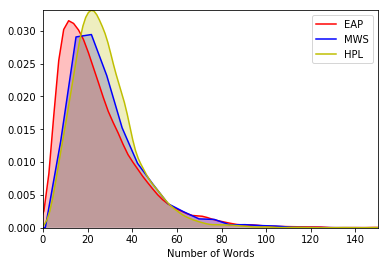

In [6]:
train_feats['length'] = train_feats['text'].apply(lambda t: len(t.split()))
plot_distribution(sentence_stat = 'length', xlim = (0, 150), xlabel = 'Number of Words')

Seems that EAP tended to write in shorter sentences than MWS and HPL. Then let's look at the proportion of unique words in the sentences.

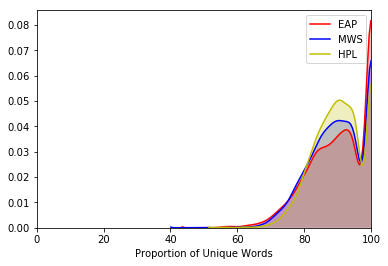

In [7]:
train_feats['unique'] = train_feats['text'].apply(lambda t: 100*float(len(np.unique(t.split())))/float(len(t.split())))
plot_distribution(sentence_stat = 'unique', xlim = (0, 100), xlabel = 'Proportion of Unique Words')

There seems to be no obvious difference between the three authors. Then let's look at the proportion of stop words in the sentence.

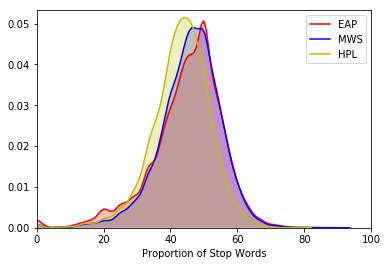

In [8]:
def count_stop_word(text):
    return len([w for w in word_tokenize(text) if w in stopwords.words('english')])

train_feats['stop'] = train_feats['text'].apply(lambda t: 100*float(count_stop_word(t))/float(len(t.split())))
plot_distribution(sentence_stat = 'stop', xlim = (0, 100), xlabel = 'Proportion of Stop Words')

Seems that HPL tended to use fewer stop words than EAP and MWS. Then let's look at the proportion of punctuations in the sentence. Since punctuation is a single character, we normalize the number of punctuations using number of characters in the sentence.

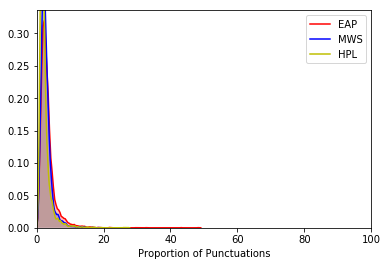

In [9]:
def count_punctuation(text):
    return len([c for c in text if c in string.punctuation])

train_feats['punctuation'] = train_feats['text'].apply(lambda t: 100*float(count_punctuation(t))/float(len(t)))
plot_distribution(sentence_stat = 'punctuation', xlim = (0, 100), xlabel = 'Proportion of Punctuations')

Similar to stop words, seems that HPL tended to use fewer punctuations than EAP and MWS. Then let's look at the proportion of nouns and verbs in the sentence.

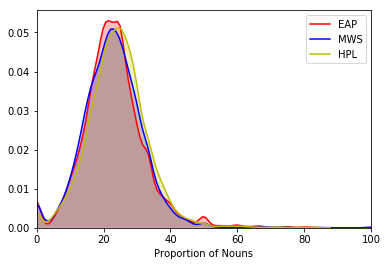

In [10]:
def count_noun(text):
    freq = FreqDist(tag for (word, tag) in pos_tag(word_tokenize(text)))
    noun_num = sum(num for tag, num in freq.items() if tag in ['NN', 'NNP', 'NNS'])
    return noun_num

train_feats['noun'] = train_feats['text'].apply(lambda t: 100*float(count_noun(t))/float(len(t.split())))
plot_distribution(sentence_stat = 'noun', xlim = (0, 100), xlabel = 'Proportion of Nouns')

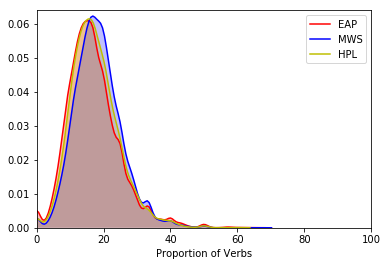

In [11]:
def count_verb(text):
    freq = FreqDist(tag for (word, tag) in pos_tag(word_tokenize(text)))
    verb_num = sum(num for tag, num in freq.items() if tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'])
    return verb_num

train_feats['verb'] = train_feats['text'].apply(lambda t: 100*float(count_verb(t))/float(len(t.split())))
plot_distribution(sentence_stat = 'verb', xlim = (0, 100), xlabel = 'Proportion of Verbs')

Seems that MWS used more verbs than EAP and HPL.